C:\Users\luisf\AppData\Local\Temp\ipykernel_24064\3658090950.py:9: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class PlotUpdater(QMainWindow):


SystemExit: 0

C:\Users\luisf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


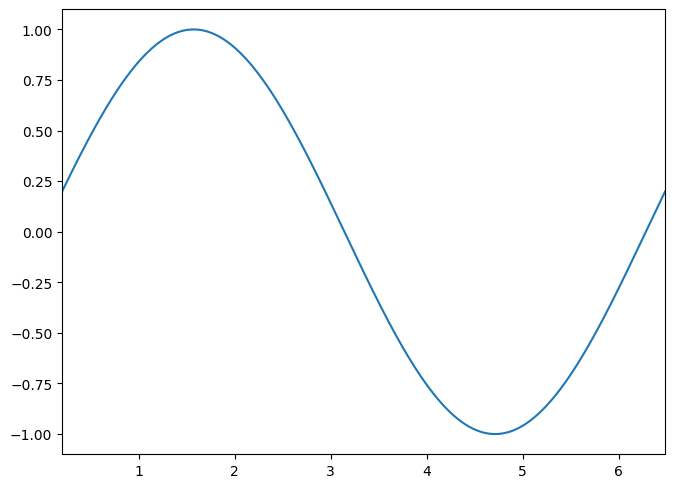

In [2]:

5

Some years ago, I already experimented with embedding live matplotlib plots in a PyQt5 GUI. Live plots show a data-stream real-time, captured from a sensor, some process, ... I got that working, and you can read the related posts here:

    Matplotlib animation inside your own GUI

    How do I plot in real-time in a while loop using matplotlib?

Now I need to do the same thing again. I remember my previous approach worked, but couldn't keep up with fast datastreams. I found a couple of example codes on the internet, that I'd like to present to you. One of them is clearly faster than the other, but I don't know why. I'd like to gain more insights. I believe a deeper understanding will enable me to keep my interactions with PyQt5 and matplotlib efficient.

 
1. First example

This example is based on this article:
https://matplotlib.org/3.1.1/gallery/user_interfaces/embedding_in_qt_sgskip.html
The article is from the official matplotlib website, and explains how to embed a matplotlib figure in a PyQt5 window.

I did a few minor adjustments to the example code, but the basics are still the same. Please copy-paste the code below to a Python file and run it:

#####################################################################################
#                                                                                   #
#                PLOT A LIVE GRAPH IN A PYQT WINDOW                                 #
#                EXAMPLE 1                                                          #
#               ------------------------------------                                #
# This code is inspired on:                                                         #
# https://matplotlib.org/3.1.1/gallery/user_interfaces/embedding_in_qt_sgskip.html  #
#                                                                                   #
#####################################################################################

from __future__ import annotations
from typing import *
import sys
import os
from matplotlib.backends.qt_compat import QtCore, QtWidgets
# from PyQt5 import QtWidgets, QtCore
from matplotlib.backends.backend_qt5agg import FigureCanvas
# from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import matplotlib as mpl
import numpy as np

class ApplicationWindow(QtWidgets.QMainWindow):
    '''
    The PyQt5 main window.

    '''
    def __init__(self):
        super().__init__()
        # 1. Window settings
        self.setGeometry(300, 300, 800, 400)
        self.setWindowTitle("Matplotlib live plot in PyQt - example 1")
        self.frm = QtWidgets.QFrame(self)
        self.frm.setStyleSheet("QWidget { background-color: #eeeeec; }")
        self.lyt = QtWidgets.QVBoxLayout()
        self.frm.setLayout(self.lyt)
        self.setCentralWidget(self.frm)

        # 2. Place the matplotlib figure
        self.myFig = MyFigureCanvas(x_len=200, y_range=[0, 100], interval=20)
        self.lyt.addWidget(self.myFig)

        # 3. Show
        self.show()
        return

class MyFigureCanvas(FigureCanvas):
    '''
    This is the FigureCanvas in which the live plot is drawn.

    '''
    def __init__(self, x_len:int, y_range:List, interval:int) -> None:
        '''
        :param x_len:       The nr of data points shown in one plot.
        :param y_range:     Range on y-axis.
        :param interval:    Get a new datapoint every .. milliseconds.

        '''
        super().__init__(mpl.figure.Figure())
        # Range settings
        self._x_len_ = x_len
        self._y_range_ = y_range

        # Store two lists _x_ and _y_
        self._x_ = list(range(0, x_len))
        self._y_ = [0] * x_len

        # Store a figure ax
        self._ax_ = self.figure.subplots()

        # Initiate the timer
        self._timer_ = self.new_timer(interval, [(self._update_canvas_, (), {})])
        self._timer_.start()
        return

    def _update_canvas_(self) -> None:
        '''
        This function gets called regularly by the timer.

        '''
        self._y_.append(round(get_next_datapoint(), 2))     # Add new datapoint
        self._y_ = self._y_[-self._x_len_:]                 # Truncate list _y_
        self._ax_.clear()                                   # Clear ax
        self._ax_.plot(self._x_, self._y_)                  # Plot y(x)
        self._ax_.set_ylim(ymin=self._y_range_[0], ymax=self._y_range_[1])
        self.draw()
        return

# Data source
# ------------
n = np.linspace(0, 499, 500)
d = 50 + 25 * (np.sin(n / 8.3)) + 10 * (np.sin(n / 7.5)) - 5 * (np.sin(n / 1.5))
i = 0
def get_next_datapoint():
    global i
    i += 1
    if i > 499:
        i = 0
    return d[i]

if __name__ == "__main__":
    qapp = QtWidgets.QApplication(sys.argv)
    app = ApplicationWindow()
    qapp.exec_()

You should see the following window:

enter image description here

 
2. Second example

I found another example of live matplotlib graphs here:
https://learn.sparkfun.com/tutorials/graph-sensor-data-with-python-and-matplotlib/speeding-up-the-plot-animation
However, the author doesn't use PyQt5 to embed his live plot. Therefore, I've modified the code a bit, to get the plot in a PyQt5 window:

#####################################################################################
#                                                                                   #
#                PLOT A LIVE GRAPH IN A PYQT WINDOW                                 #
#                EXAMPLE 2                                                          #
#               ------------------------------------                                #
# This code is inspired on:                                                         #
# https://learn.sparkfun.com/tutorials/graph-sensor-data-with-python-and-matplotlib/speeding-up-the-plot-animation  #
#                                                                                   #
#####################################################################################

from __future__ import annotations
from typing import *
import sys
import os
from matplotlib.backends.qt_compat import QtCore, QtWidgets
# from PyQt5 import QtWidgets, QtCore
from matplotlib.backends.backend_qt5agg import FigureCanvas
# from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import matplotlib as mpl
import matplotlib.figure as mpl_fig
import matplotlib.animation as anim
import numpy as np

class ApplicationWindow(QtWidgets.QMainWindow):
    '''
    The PyQt5 main window.

    '''
    def __init__(self):
        super().__init__()
        # 1. Window settings
        self.setGeometry(300, 300, 800, 400)
        self.setWindowTitle("Matplotlib live plot in PyQt - example 2")
        self.frm = QtWidgets.QFrame(self)
        self.frm.setStyleSheet("QWidget { background-color: #eeeeec; }")
        self.lyt = QtWidgets.QVBoxLayout()
        self.frm.setLayout(self.lyt)
        self.setCentralWidget(self.frm)

        # 2. Place the matplotlib figure
        self.myFig = MyFigureCanvas(x_len=200, y_range=[0, 100], interval=20)
        self.lyt.addWidget(self.myFig)

        # 3. Show
        self.show()
        return

class MyFigureCanvas(FigureCanvas, anim.FuncAnimation):
    '''
    This is the FigureCanvas in which the live plot is drawn.

    '''
    def __init__(self, x_len:int, y_range:List, interval:int) -> None:
        '''
        :param x_len:       The nr of data points shown in one plot.
        :param y_range:     Range on y-axis.
        :param interval:    Get a new datapoint every .. milliseconds.

        '''
        FigureCanvas.__init__(self, mpl_fig.Figure())
        # Range settings
        self._x_len_ = x_len
        self._y_range_ = y_range

        # Store two lists _x_ and _y_
        x = list(range(0, x_len))
        y = [0] * x_len

        # Store a figure and ax
        self._ax_  = self.figure.subplots()
        self._ax_.set_ylim(ymin=self._y_range_[0], ymax=self._y_range_[1])
        self._line_, = self._ax_.plot(x, y)

        # Call superclass constructors
        anim.FuncAnimation.__init__(self, self.figure, self._update_canvas_, fargs=(y,), interval=interval, blit=True)
        return

    def _update_canvas_(self, i, y) -> None:
        '''
        This function gets called regularly by the timer.

        '''
        y.append(round(get_next_datapoint(), 2))     # Add new datapoint
        y = y[-self._x_len_:]                        # Truncate list _y_
        self._line_.set_ydata(y)
        return self._line_,

# Data source
# ------------
n = np.linspace(0, 499, 500)
d = 50 + 25 * (np.sin(n / 8.3)) + 10 * (np.sin(n / 7.5)) - 5 * (np.sin(n / 1.5))
i = 0
def get_next_datapoint():
    global i
    i += 1
    if i > 499:
        i = 0
    return d[i]

if __name__ == "__main__":
    qapp = QtWidgets.QApplication(sys.argv)
    app = ApplicationWindow()
    qapp.exec_()

The resulting live plot is exactly the same. However, if you start playing around with the interval parameter from the MyFigureCanvas() constructor, you will notice that the first example won't be able to follow. The second example can go much faster.

 
3. Questions

I've got a couple of questions I'd like to present to you:

    The QtCore and QtWidgets classes can be imported like this:
    from matplotlib.backends.qt_compat import QtCore, QtWidgets
    or like this:
    from PyQt5 import QtWidgets, QtCore
    Both work equally well. Is there a reason to prefer one over the other?
     

    The FigureCanvas can be imported like this:
    from matplotlib.backends.backend_qt5agg import FigureCanvas
    or like this: from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
    But I already figured out why. The backend_qt5agg file seems to define FigureCanvas as an alias for FigureCanvasQTAgg.
     

    Why exactly is the second example so much faster than the first one? Honestly, it surprises me. The first example is based on a webpage from the official matplotlib website. I'd expect that one to be better.
     

    Do you have any suggestions to make the second example even faster?

 
4. Edits

Based on the webpage:
https://bastibe.de/2013-05-30-speeding-up-matplotlib.html
I modified the first example to increase its speed. Please have a look at the code:

#####################################################################################
#                                                                                   #
#                PLOT A LIVE GRAPH IN A PYQT WINDOW                                 #
#                EXAMPLE 1 (modified for extra speed)                               #
#               --------------------------------------                              #
# This code is inspired on:                                                         #
# https://matplotlib.org/3.1.1/gallery/user_interfaces/embedding_in_qt_sgskip.html  #
# and on:                                                                           #
# https://bastibe.de/2013-05-30-speeding-up-matplotlib.html                         #
#                                                                                   #
#####################################################################################

from __future__ import annotations
from typing import *
import sys
import os
from matplotlib.backends.qt_compat import QtCore, QtWidgets
# from PyQt5 import QtWidgets, QtCore
from matplotlib.backends.backend_qt5agg import FigureCanvas
# from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import matplotlib as mpl
import numpy as np

class ApplicationWindow(QtWidgets.QMainWindow):
    '''
    The PyQt5 main window.

    '''
    def __init__(self):
        super().__init__()
        # 1. Window settings
        self.setGeometry(300, 300, 800, 400)
        self.setWindowTitle("Matplotlib live plot in PyQt - example 1 (modified for extra speed)")
        self.frm = QtWidgets.QFrame(self)
        self.frm.setStyleSheet("QWidget { background-color: #eeeeec; }")
        self.lyt = QtWidgets.QVBoxLayout()
        self.frm.setLayout(self.lyt)
        self.setCentralWidget(self.frm)

        # 2. Place the matplotlib figure
        self.myFig = MyFigureCanvas(x_len=200, y_range=[0, 100], interval=1)
        self.lyt.addWidget(self.myFig)

        # 3. Show
        self.show()
        return

class MyFigureCanvas(FigureCanvas):
    '''
    This is the FigureCanvas in which the live plot is drawn.

    '''
    def __init__(self, x_len:int, y_range:List, interval:int) -> None:
        '''
        :param x_len:       The nr of data points shown in one plot.
        :param y_range:     Range on y-axis.
        :param interval:    Get a new datapoint every .. milliseconds.

        '''
        super().__init__(mpl.figure.Figure())
        # Range settings
        self._x_len_ = x_len
        self._y_range_ = y_range

        # Store two lists _x_ and _y_
        self._x_ = list(range(0, x_len))
        self._y_ = [0] * x_len

        # Store a figure ax
        self._ax_ = self.figure.subplots()
        self._ax_.set_ylim(ymin=self._y_range_[0], ymax=self._y_range_[1]) # added
        self._line_, = self._ax_.plot(self._x_, self._y_)                  # added
        self.draw()                                                        # added

        # Initiate the timer
        self._timer_ = self.new_timer(interval, [(self._update_canvas_, (), {})])
        self._timer_.start()
        return

    def _update_canvas_(self) -> None:
        '''
        This function gets called regularly by the timer.

        '''
        self._y_.append(round(get_next_datapoint(), 2))     # Add new datapoint
        self._y_ = self._y_[-self._x_len_:]                 # Truncate list y

        # Previous code
        # --------------
        # self._ax_.clear()                                   # Clear ax
        # self._ax_.plot(self._x_, self._y_)                  # Plot y(x)
        # self._ax_.set_ylim(ymin=self._y_range_[0], ymax=self._y_range_[1])
        # self.draw()

        # New code
        # ---------
        self._line_.set_ydata(self._y_)
        self._ax_.draw_artist(self._ax_.patch)
        self._ax_.draw_artist(self._line_)
        self.update()
        self.flush_events()
        return

# Data source
# ------------
n = np.linspace(0, 499, 500)
d = 50 + 25 * (np.sin(n / 8.3)) + 10 * (np.sin(n / 7.5)) - 5 * (np.sin(n / 1.5))
i = 0
def get_next_datapoint():
    global i
    i += 1
    if i > 499:
        i = 0
    return d[i]

if __name__ == "__main__":
    qapp = QtWidgets.QApplication(sys.argv)
    app = ApplicationWindow()
    qapp.exec_()



C:\Users\luisf\AppData\Local\Temp\ipykernel_38712\3835986857.py:10: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class PlotUpdater(QMainWindow):


Program initiated
Connection to Cyton board established successfully!
[[0.00000000e+00 1.00000000e+00 2.00000000e+00 ... 2.50000000e+02
  2.51000000e+02 2.52000000e+02]
 [1.16966975e+01 1.36303107e+01 1.53771418e+01 ... 1.17787873e+01
  1.35241173e+01 1.51536187e+01]
 [2.82545807e+01 3.55313589e+01 4.13867332e+01 ... 2.91958206e+01
  3.63087932e+01 3.85260106e+01]
 ...
 [8.30045774e+01 8.12560017e+01 9.34063812e+01 ... 9.97434049e+01
  9.34886706e+01 9.44816445e+01]
 [1.70940543e+09 1.70940543e+09 1.70940543e+09 ... 1.70940543e+09
  1.70940543e+09 1.70940543e+09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
window opened
entering sleep
done sleeping
window should be closed by now
Session ended


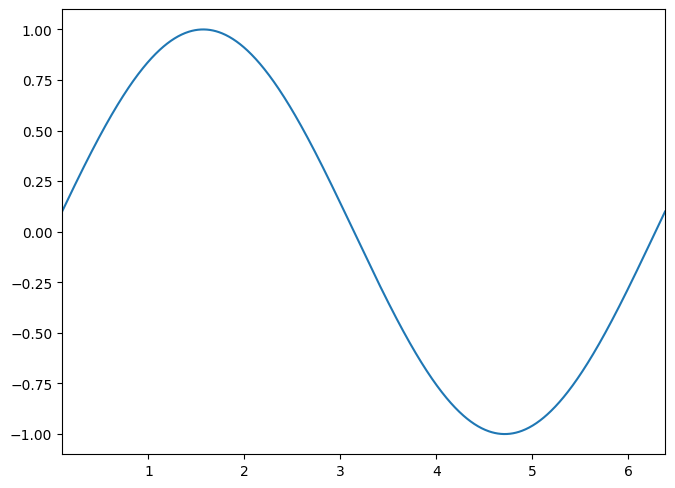

In [3]:
import sys
from functions_openBCI import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from PyQt5.QtWidgets import QMainWindow, QApplication, QVBoxLayout, QWidget
from PyQt5 import QtCore

class PlotUpdater(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("EEG electrodes")
        self.setGeometry(100, 100, 800, 600)

        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        self.layout = QVBoxLayout()
        self.central_widget.setLayout(self.layout)

        self.fig, self.ax = plt.subplots()
        self.canvas = FigureCanvas(self.fig)
        self.layout.addWidget(self.canvas)

        self.x = np.linspace(0, 2 * np.pi, 1000)
        self.y = np.sin(self.x)

        self.line, = self.ax.plot(self.x, self.y)
        self.animation_timer = QtCore.QTimer(self)
        self.animation_timer.timeout.connect(self.update_plot)
        self.animation_timer.start(2000)  # Update plot every 50 milliseconds

    def update_plot(self):
        # Shift the sine wave to the right
        self.x += 0.1
        self.y = np.sin(self.x)

        # Update the data of the line plot
        self.line.set_xdata(self.x)
        self.line.set_ydata(self.y)

        # Adjust plot limits to keep the sine wave visible
        self.ax.set_xlim(self.x.min(), self.x.max())
        self.ax.set_ylim(-1.1, 1.1)

        # Redraw the plot
        self.canvas.draw()


if __name__ == "aaa":
    app = QApplication(sys.argv)
    window = PlotUpdater()
    window.show()
    sys.exit(app.exec_())

if  __name__ =="__main__":
    
    print("Program initiated")
    btype = "other" # [cyton, other]
    cyton = open_board(btype)
    time.sleep(1)
    signal = cyton.get_board_data();
    print(signal)
    
    app = QApplication(sys.argv)
    window = PlotUpdater()
    print("window opened")
    
    #window.update_data(signal)
    window.show()
    window.update_plot()
    print("entering sleep")
    time.sleep(50)
#   signal = cyton.get_board_data(); 
    print("done sleeping")
    
    window.close()
    print("window should be closed by now")

close_board(cyton)


In [2]:
close_board(cyton)


Session ended


In [4]:
####################################################################################
#                                                                                   #
#                PLOT A LIVE GRAPH IN A PYQT WINDOW                                 #
#                EXAMPLE 2                                                          #
#               ------------------------------------                                #
# This code is inspired on:                                                         #
# https://learn.sparkfun.com/tutorials/graph-sensor-data-with-python-and-matplotlib/speeding-up-the-plot-animation  #
#                                                                                   #
#####################################################################################

from __future__ import annotations
from typing import *
import sys
import os
from matplotlib.backends.qt_compat import QtCore, QtWidgets
# from PyQt5 import QtWidgets, QtCore
from matplotlib.backends.backend_qt5agg import FigureCanvas
# from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
import matplotlib as mpl
import matplotlib.figure as mpl_fig
import matplotlib.animation as anim
import numpy as np

class ApplicationWindow(QtWidgets.QMainWindow):
    '''
    The PyQt5 main window.

    '''
    def __init__(self):
        super().__init__()
        # 1. Window settings
        self.setGeometry(300, 300, 800, 400)
        self.setWindowTitle("Matplotlib live plot in PyQt - example 2")
        self.frm = QtWidgets.QFrame(self)
        self.frm.setStyleSheet("QWidget { background-color: #eeeeec; }")
        self.lyt = QtWidgets.QVBoxLayout()
        self.frm.setLayout(self.lyt)
        self.setCentralWidget(self.frm)

        # 2. Place the matplotlib figure
        self.myFig = MyFigureCanvas(x_len=200, y_range=[0, 100], interval=20)
        self.lyt.addWidget(self.myFig)

        # 3. Show
        self.show()
        return

class MyFigureCanvas(FigureCanvas, anim.FuncAnimation):
    '''
    This is the FigureCanvas in which the live plot is drawn.

    '''
    def __init__(self, x_len:int, y_range:List, interval:int) -> None:
        '''
        :param x_len:       The nr of data points shown in one plot.
        :param y_range:     Range on y-axis.
        :param interval:    Get a new datapoint every .. milliseconds.

        '''
        FigureCanvas.__init__(self, mpl_fig.Figure())
        # Range settings
        self._x_len_ = x_len
        self._y_range_ = y_range

        # Store two lists _x_ and _y_
        x = list(range(0, x_len))
        y = [0] * x_len

        # Store a figure and ax
        self._ax_  = self.figure.subplots()
        self._ax_.set_ylim(ymin=self._y_range_[0], ymax=self._y_range_[1])
        self._line_, = self._ax_.plot(x, y)

        # Call superclass constructors
        anim.FuncAnimation.__init__(self, self.figure, self._update_canvas_, fargs=(y,), interval=interval, blit=True)
        return

    def _update_canvas_(self, i, y) -> None:
        '''
        This function gets called regularly by the timer.

        '''
        y.append(round(get_next_datapoint(), 2))     # Add new datapoint
        y = y[-self._x_len_:]                        # Truncate list _y_
        self._line_.set_ydata(y)
        return self._line_,

# Data source
# ------------
n = np.linspace(0, 499, 500)
d = 50 + 25 * (np.sin(n / 8.3)) + 10 * (np.sin(n / 7.5)) - 5 * (np.sin(n / 1.5))
i = 0
def get_next_datapoint():
    global i
    i += 1
    if i > 499:
        i = 0
    return d[i]

if __name__ == "__main__":
    qapp = QtWidgets.QApplication(sys.argv)
    app = ApplicationWindow()
    qapp.exec_()


C:\Users\luisf\AppData\Local\Temp\ipykernel_38712\1360247324.py:24: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class ApplicationWindow(QtWidgets.QMainWindow):
C:\Users\luisf\AppData\Local\Temp\ipykernel_38712\1360247324.py:48: DeprecationWarning: sipPyTypeDict() is deprecated, the extension module should use sipPyTypeDictRef() instead
  class MyFigureCanvas(FigureCanvas, anim.FuncAnimation):


TypeError: __init__() missing 2 required positional arguments: 'fig' and 'func'

In [5]:
sudo apt-get update

SyntaxError: invalid syntax (1482663245.py, line 1)

In [6]:
import os
os.environ.get('PYTHONPATH', '').split(os.pathsep)

['']